### 1. Instalar bibliotecas

Esta célula instala as bibliotecas Python necessárias para o projeto, incluindo `transformers` (para usar modelos do Hugging Face), `Pillow` (para manipulação de imagens), `requests` (para baixar imagens, embora não seja estritamente necessário para imagens locais), e as bibliotecas do Azure AI Vision (`azure-ai-vision-imageanalysis` e `azure-core`).

In [ ]:
%pip install --upgrade pip
%pip install "transformers>=4.40" Pillow requests "azure-ai-vision-imageanalysis>=1.0.0b3" azure-core torch torchvision torchaudio
# Em Colab pode ser necessário: apt-get install -y libgl1 (para exibir imagens com cv2)

### 2. Carregar o modelo de detecção de objetos do Hugging Face

Aqui carregamos o processador e o modelo `nickmuchi/yolos-small-finetuned-license-plate-detection` do Hugging Face Hub. Este modelo é treinado para detectar objetos do tipo "license-plates" (placas de veículos) em imagens.

In [2]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor

model_name = "nickmuchi/yolos-small-finetuned-license-plate-detection"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForObjectDetection.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### 3. Carregar a imagem original

Esta célula carrega a imagem local `/content/print_moto_placa.png` usando a biblioteca Pillow. A imagem é convertida para o formato RGB para garantir compatibilidade com o modelo.

In [ ]:
from PIL import Image
import os

# Tenta resolver o caminho da imagem localmente e no Colab; se não existir, pede upload (apenas Colab)
candidate_paths = [
    "print_moto_placa.png",
    "./print_moto_placa.png",
    "/content/print_moto_placa.png",
]
image_path = next((p for p in candidate_paths if os.path.exists(p)), None)

if image_path is None:
    try:
        from google.colab import files  # type: ignore
        print("Imagem não encontrada no caminho padrão. Faça upload do arquivo 'print_moto_placa.png'.")
        uploaded = files.upload()
        image_path = next(iter(uploaded.keys()))
    except Exception as e:
        raise FileNotFoundError(
            "Imagem 'print_moto_placa.png' não encontrada. Coloque-a na raiz do repositório ou faça upload no Colab."
        ) from e

image = Image.open(image_path).convert("RGB")

### 4. Realizar a detecção de objetos

Aqui, a imagem carregada é processada e passada para o modelo de detecção de objetos do Hugging Face para realizar a inferência. Os resultados contêm informações sobre os objetos detectados, incluindo suas caixas delimitadoras e scores de confiança. Ajustamos o `threshold` para 0.5 para considerar detecções com confiança razoável.

In [4]:
import torch

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
# Ajuste o threshold conforme necessário
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

# Exibir os resultados da detecção de objetos
print("Resultados da detecção de objetos:")
if len(results["scores"]) > 0:
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_text = model.config.id2label[label.item()]
        box_list = [round(i, 2) for i in box.tolist()]
        print(
            f"  Objeto detectado: {label_text} com confiança {round(score.item(), 3)} na localização {box_list}"
        )
else:
    print("Nenhum objeto detectado com o threshold atual.")

Resultados da detecção de objetos:
  Objeto detectado: license-plates com confiança 1.0 na localização [123.11, 296.41, 303.36, 534.9]


### 5. Visualizar a detecção na imagem original

Esta célula desenha a caixa delimitadora detectada pelo modelo do Hugging Face na imagem original usando a biblioteca Pillow. Isso ajuda a visualizar onde o modelo identificou a placa de veículo. A imagem com a caixa desenhada é então exibida.

Caixa delimitadora desenhada na imagem original nas coordenadas: [123, 296, 303, 534]

Imagem original com a caixa delimitadora da placa detectada:


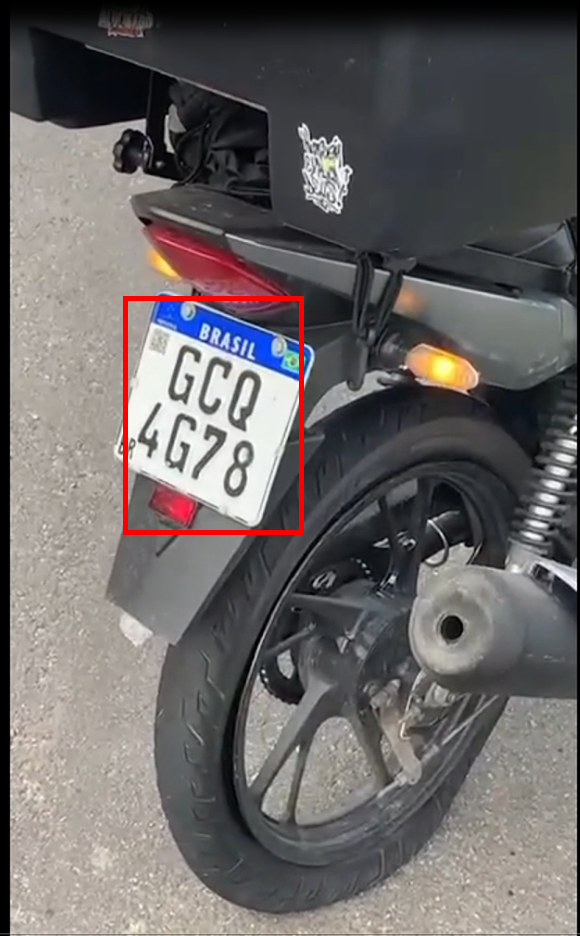

In [5]:
from PIL import ImageDraw

# Criar uma cópia da imagem original para desenhar
image_with_box = image.copy()
draw = ImageDraw.Draw(image_with_box)

# Define color for the bounding box outline
box_color = "red"

# Get the bounding box coordinates from the results
# results["boxes"] contains coordinates in the format [x1, y1, x2, y2]
# Verificar se há detecções antes de tentar desenhar
if results and results["boxes"] is not None and len(results["boxes"]) > 0:
    # Assumindo que queremos desenhar a caixa da primeira detecção (que deve ser a placa)
    box = results["boxes"][0].tolist()
    x1, y1, x2, y2 = box

    # Draw a rectangle on the image using the bounding box coordinates
    # Convert coordinates to integers for drawing
    draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))], outline=box_color, width=5)
    print(f"Caixa delimitadora desenhada na imagem original nas coordenadas: {[int(x1), int(y1), int(x2), int(y2)]}")
else:
    print("Nenhuma caixa delimitadora para desenhar (nenhuma placa detectada com o threshold atual).")


# Display the image with the drawn bounding box
print("\nImagem original com a caixa delimitadora da placa detectada:")
display(image_with_box)

### 6. Recortar a área da placa

Usando as coordenadas da caixa delimitadora da primeira detecção (assumindo que é a placa), esta célula recorta a região correspondente da imagem original. Esta imagem recortada contém apenas a área da placa de veículo.

In [6]:
# Coordenadas da caixa delimitadora da placa detectada (arredondadas para inteiros)
# As coordenadas estão no formato [x1, y1, x2, y2]
# x1: canto superior esquerdo X
# y1: canto superior esquerdo Y
# x2: canto inferior direito X
# y2: canto inferior direito Y

# Verificar se há detecções antes de tentar recortar
if results and results["boxes"] is not None and len(results["boxes"]) > 0:
    box_coords = results["boxes"][0].tolist() # Pegar as coordenadas do primeiro (e único) objeto detectado
    x1, y1, x2, y2 = [int(round(coord)) for coord in box_coords]

    # Recortar a imagem para a área da caixa delimitadora
    cropped_plate_image = image.crop((x1, y1, x2, y2))
    print(f"Imagem recortada usando as coordenadas: {[x1, y1, x2, y2]}")
else:
     cropped_plate_image = None # Definir como None se nenhuma placa for detectada
     print("Nenhuma placa detectada para recortar.")

Imagem recortada usando as coordenadas: [123, 296, 303, 535]


### 7. Exibir a imagem recortada

Esta célula exibe a imagem que foi recortada na etapa anterior, mostrando apenas a área da placa de veículo detectada.


Imagem recortada da placa:


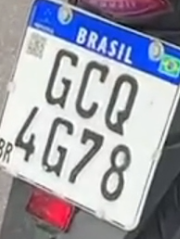

In [7]:
# Exibir a imagem recortada, se ela existir
if cropped_plate_image:
    print("\nImagem recortada da placa:")
    display(cropped_plate_image)
else:
    print("\nNão há imagem recortada para exibir (nenhuma placa foi detectada).")

### 8. Configurar o cliente Azure AI Vision

Inicializa o cliente para o serviço Azure AI Vision usando seu endpoint e chave de assinatura. Este cliente será usado para realizar a análise de imagem, especificamente o OCR (leitura de texto).

In [ ]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.core.credentials import AzureKeyCredential
import io  # Importar io para lidar com bytes da imagem
import os

# Configure as credenciais via variáveis de ambiente para evitar expor chaves no código
# No Colab, execute antes: os.environ["VISION_ENDPOINT"] = "<seu-endpoint>"; os.environ["VISION_KEY"] = "<sua-chave>"
endpoint = os.getenv("VISION_ENDPOINT")
key = os.getenv("VISION_KEY")

if not endpoint or not key:
    raise EnvironmentError(
        "Defina as variáveis de ambiente VISION_ENDPOINT e VISION_KEY antes de executar."
    )

client = ImageAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

### 9. Realizar OCR na imagem recortada

Esta célula converte a imagem recortada da placa para um formato de bytes e a envia para o serviço Azure AI Vision usando o recurso `VisualFeatures.READ`. O serviço de OCR do Azure tentará extrair qualquer texto presente na imagem recortada.

In [9]:
from azure.ai.vision.imageanalysis.models import VisualFeatures

# Verificar se há uma imagem recortada antes de tentar OCR
if cropped_plate_image:
    # Converter a imagem recortada para bytes
    with io.BytesIO() as output:
        cropped_plate_image.save(output, format='PNG') # Salvar como PNG ou outro formato adequado
        image_bytes = output.getvalue()

    # Chamar o cliente Azure AI Vision para performar OCR (READ feature) na imagem recortada
    print("\nRealizando OCR na imagem recortada da placa...")
    ocr_results = client.analyze(
        image_data=image_bytes,
        visual_features=[VisualFeatures.READ]
    )
else:
    ocr_results = None
    print("\nNão há imagem recortada para realizar OCR.")


Realizando OCR na imagem recortada da placa...


### 10. Exibir os resultados do OCR

Finalmente, esta célula exibe o texto que foi extraído da imagem recortada da placa pelo serviço Azure AI Vision.

In [ ]:
# Display the extracted text from the OCR results e salvar em arquivo
import os
os.makedirs("results", exist_ok=True)

print("\nResultados do OCR na imagem recortada:")
ocr_text_lines = []
if ocr_results is not None and ocr_results.read is not None:
    for block in ocr_results.read.blocks:
        for line in block.lines:
            ocr_text_lines.append(line.text)
            print(f"  Line: '{line.text}'")
            for word in line.words:
                pass  # opcional imprimir confidences
else:
    print("  Nenhum texto detectado na imagem recortada ou OCR não foi realizado.")

# Salvar texto extraído
with open(os.path.join("results", "ocr_plate.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(ocr_text_lines))

# Também salvar imagens de evidência se existirem
try:
    image_with_box.save(os.path.join("results", "original_with_bbox.png"))
except Exception:
    pass
try:
    if 'cropped_plate_image' in globals() and cropped_plate_image is not None:
        cropped_plate_image.save(os.path.join("results", "cropped_plate.png"))
except Exception:
    pass


Resultados do OCR na imagem recortada:
  Line: 'BRASIL'
    Word: 'BRASIL', Confidence: 0.9940
  Line: 'GCQ'
    Word: 'GCQ', Confidence: 0.9930
  Line: '4G78'
    Word: '4G78', Confidence: 0.9390


### 11. Métricas e comparação entre abordagens

Nesta seção registramos métricas simples (tempo de inferência e confiança média) para a abordagem Hugging Face (detecção) + Azure (OCR). Em seguida, você pode executar o workflow do Roboflow (opcional) e comparar qualitativamente/quantitativamente no README.

In [ ]:
import time, json, statistics, os

metrics = {}

# Medir tempo da detecção (Hugging Face)
start = time.time()
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
results_tmp = processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.5)[0]
end = time.time()

scores = [s.item() for s in results_tmp["scores"]] if len(results_tmp["scores"])>0 else []
metrics["detection"] = {
    "latency_sec": round(end - start, 4),
    "num_boxes": len(scores),
    "avg_confidence": round(statistics.mean(scores), 4) if scores else 0.0,
}

# Medir tempo do OCR (Azure) se houver crop
if 'cropped_plate_image' in globals() and cropped_plate_image is not None:
    import io
    with io.BytesIO() as output:
        cropped_plate_image.save(output, format='PNG')
        image_bytes = output.getvalue()
    start = time.time()
    ocr_tmp = client.analyze(image_data=image_bytes, visual_features=[VisualFeatures.READ])
    end = time.time()
    metrics["ocr"] = {"latency_sec": round(end - start, 4), "has_text": bool(ocr_tmp and ocr_tmp.read and ocr_tmp.read.blocks)}
else:
    metrics["ocr"] = {"latency_sec": None, "has_text": False}

os.makedirs("results", exist_ok=True)
with open(os.path.join("results", "metrics_hf_azure.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("Métricas salvas em results/metrics_hf_azure.json")
print(json.dumps(metrics, indent=2))